In [1]:
#using processed GIPM & FGM data
#import modules
import pandas as pd
from XMA_finder import XMA_finder
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
from merka05_surface_eq_array_GIPM import merka05_surface_eq_array_GIPM
import glob
from histo_plot_low_vmax import histo_plot
import numpy as np

In [2]:
#read in raw CSVs for Cluster

##RADIAL CONE ANGLE

cluster_rad_list = []

rad_path = "/Users/apx059/Documents/1_Yr_Data/1 Year GIPM Sorted/Radial/**"
rad_list_all = []

for path in glob.glob(rad_path, recursive=True):
    rad_list_all.append(path)
    
#list with only files, not folders

for element in rad_list_all:
    if '.csv' in element:
        cluster_rad_list.append(element)
        
rad_cl_dfs = []

for file in cluster_rad_list:
    df = pd.read_csv(file)
    df['window start'] = pd.to_datetime(df['window start'],format='mixed')
    df = df.set_index('window start')
    rad_cl_dfs.append(df)
    
##SPIRAL CONE ANGLE

cluster_spir_list = []

spir_path = "/Users/apx059/Documents/1_Yr_Data/1 Year GIPM Sorted/Spiral/**"
spir_list_all = []

for path in glob.glob(spir_path, recursive=True):
    spir_list_all.append(path)
    
#list with only files, not folders

for element in spir_list_all:
    if '.csv' in element:
        cluster_spir_list.append(element)
        
spir_cl_dfs = []

for file in cluster_spir_list:
    df = pd.read_csv(file)
    df['window start'] = pd.to_datetime(df['window start'],format='mixed')
    df = df.set_index('window start')
    spir_cl_dfs.append(df)
    
##PERP CONE ANGLE

cluster_perp_list = []

perp_path = "/Users/apx059/Documents/1_Yr_Data/1 Year GIPM Sorted/Perpendicular/**"
perp_list_all = []

for path in glob.glob(perp_path, recursive=True):
    perp_list_all.append(path)
    
#list with only files, not folders

for element in perp_list_all:
    if '.csv' in element:
        cluster_perp_list.append(element)
        
perp_cl_dfs = []

for file in cluster_perp_list:
    df = pd.read_csv(file)
    df['window start'] = pd.to_datetime(df['window start'],format='mixed')
    df = df.set_index('window start')
    perp_cl_dfs.append(df)

In [3]:
#read in CSV for OMNI averages

omni_ave_list = []

omni_path = "/Users/apx059/Documents/1_Yr_Data/1 Year GIPM Sorted/Omni Averages/**"
omni_list_all = []

for path in glob.glob(omni_path, recursive=True):
    omni_list_all.append(path)
    
#list with only files, not folders

for element in omni_list_all:
    if '.csv' in element:
        omni_ave_list.append(element)
        
omni_ave_dfs = []

for file in omni_ave_list:
    df = pd.read_csv(file)
    omni_ave_dfs.append(df)


In [4]:
#get average XMA for all events
omni_ave_all = pd.concat(omni_ave_dfs)
XMA_all = XMA_finder(omni_ave_all)

In [5]:
#join all cl_rad, cl_spir and cl_perp

all_rad = pd.concat(rad_cl_dfs)

all_spir = pd.concat(spir_cl_dfs)

all_perp = pd.concat(perp_cl_dfs)

In [6]:
#BINNING SCRIPT


def bin_lister(cluster_df, bin_size):
    
    #first mask out datapoints so only those within -5<Z<5 Re are left
    
    cluster_df_XY = cluster_df.loc[(cluster_df['Cluster Loc GIPM Z']> -5) & (cluster_df['Cluster Loc GIPM Z'] < 5)]

    #break up into X strips between 0 and 25 in increments of 0.5 Re
    #probably want to do this using lists
    #or maybe window start times??

    n = 25/bin_size
    n = int(n)
    lists = [[] for _ in range(n)]
    X_lim = 0.5
    
    for i in lists:
        #X lower bound
        X_lb = X_lim - bin_size
        #find all date times where X is within current bounds
        mask = cluster_df_XY.loc[(cluster_df_XY['Cluster Loc GIPM X']>= X_lb) & (cluster_df_XY['Cluster Loc GIPM X'] < X_lim)]
        windows = mask.index
        #and append to that list
        i.extend(windows)
        #increment X limit
        X_lim = X_lim + bin_size
    
    #now have lists of each timestamp associated with 0.5 Re width X bands
    #separate into 0.5 x 0.5 XY boxes

    n = (44/bin_size) * (25/bin_size)
    n = int(n)
    bin_lists = [[] for _ in range(n)]
    row_counter = 1

    #work by X row. i is one row, i.e. one list! of date times
    for i in lists:
        #set starting Y lim
        Y_lim = -21.5
        #mask df to just those times that are in i:
        mask = cluster_df_XY.loc[cluster_df_XY.index.isin(i)]
    
        y_bins_lower = (44/bin_size)*(row_counter-1)
        y_bins_lower = int(y_bins_lower)
        y_bins = (44/bin_size)*row_counter
        y_bins = int(y_bins)
        
        #now separate by Y bin NEED TO CHANGE Y BIN LIMS
        for j in range(y_bins_lower, y_bins): 
            Y_lb = Y_lim - bin_size
            mask_2 = mask.loc[(mask['Cluster Loc GIPM Y']>= Y_lb) & (mask['Cluster Loc GIPM Y'] < Y_lim)]
            windows = mask_2.index
            #and append to that list
            bin_lists[j].extend(windows)
            #increment X limit
            Y_lim = Y_lim + bin_size
        
        row_counter = row_counter + 1
    
    #new list of bin values
    #now for each list in bin_lists, find associated mean cluster B ratio
    #and extend new lists

    mean_ratio_perbin = []

    for j in bin_lists:
        #intermediate list for taking mean
        int_list = []
        #filter cluster database for just the times included in the binlist
        for m in j:
            mask = cluster_df_XY.loc[cluster_df_XY.index== m]
            b_rat = mask['Bc_Bo Mean']
            int_list.extend(b_rat)
        
        if len(int_list) != 0:
            mean_mean_rat = sum(int_list)/len(int_list)
            mean_ratio_perbin.append(mean_mean_rat)
        
        else:
            mean_ratio_perbin.append(np.nan)
        
    return(mean_ratio_perbin)


In [7]:
mean_rat_rad = bin_lister(all_rad, 1)
mean_rat_spir = bin_lister(all_spir, 1)
mean_rat_perp = bin_lister(all_perp, 1)

In [8]:
XMA = 10

In [9]:
#plotting function

def binned_plot(rad_list, spir_list, perp_list, bin_size):
    x = np.linspace(0, 20, 100) #x coordinates (Re)
    y = np.linspace(-30, 30, 100) #y coordinates (Re)
    z = 0 #z coordinates in Re

    [Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

    fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

    Xn = Xgipm
    Yn = Ygipm
    Zn = Zgipm
    f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

    norm = plt.Normalize(0.01,8)

    #tanfieldangle = y/x

    tan_angle_0 = np.tan(np.deg2rad(15))
    tan_angle_1 = np.tan(np.deg2rad(45))
    tan_angle_2 = np.tan(np.deg2rad(75))

    #magnetopause model, D = 2 nPa

    m_1 = 10.22
    m_2 = 1.29
    m_3 = 0.184
    m_4 = 8.14
    m_5 = 6.6
    m_6 = 0.58
    m_7 = -0.007
    m_8 = 0.024

    #use B_z =0
    B_z = 0
    D_p = 2

    alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

    tanh_angle = m_3*(B_z+m_4)
    r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

    pi = np.pi

    theta = np.arange(-pi/2, pi/2, 0.01)

    r_mod = (2/(1+np.cos(theta)))**alpha
    r = r_0*r_mod

    X_shue = r*(np.cos(theta))
    R_shue = r*(np.sin(theta))


    ###################
    fig = plt.figure(figsize=(8, 6.5))
    subfigs = fig.subfigures(1, 1)
    axsLeft = subfigs.subplots(1, 3, sharey=False)
    #gs = gridspec.GridSpec(2, 2)
    subfigs.suptitle('Mean $B_\\mathrm{CLUSTER}$/$B_\\mathrm{OMNI}$ Values, GIPM')

    #RADIAL

    x_mesh = np.arange(0, 25, bin_size) 
    y_mesh = np.arange(-22, 22, bin_size)
    col_array_r = np.array(rad_list)
    x_bin_ticks = int(25/bin_size)
    y_bin_ticks = int(44/bin_size)
    color_grid_r = col_array_r.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_r = np.rot90(color_grid_r)

    ax0 = axsLeft[0]
    ax0.pcolormesh(x_mesh, y_mesh, color_grid_r, shading='nearest', cmap='magma', norm=norm)
    ax0.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax0.plot(X_shue, R_shue, linewidth=1, color='k')

    ax0.set_aspect('equal')
    ax0.set_title(r'$\alpha$ = 0-30$\degree$')
    ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax0.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")



    #want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
    #without exceeding current bounds of plot
    inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
    X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle_0)

    #want to also have line for just solar wind flow along y=0

    ax0.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax0.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax0.set_ylim(-30,30)
    ax0.set_xlim(0,25)
    ax0.invert_xaxis()
    ax0.invert_yaxis()


    ax1 = axsLeft[1]

    #SPIRAL
    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle_1)

    #want to also have line for just solar wind flow along y=0


    col_array_1 = np.array(spir_list)
    color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_1 = np.rot90(color_grid_1)

    ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax1.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)

    ax1.pcolormesh(x_mesh, y_mesh, color_grid_1, shading='nearest', cmap='magma', norm=norm)
    ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax1.plot(X_shue, R_shue, linewidth=1, color='k')

    ax1.set_aspect('equal')
    ax1.set_title(r'$\alpha$ = 30-60$\degree$')
    ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax1.set_ylim(-30,30)
    ax1.set_xlim(0,25)
    ax1.invert_xaxis()
    ax1.invert_yaxis()

    #fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=ax1)

    #PERP

    col_array_2 = np.array(perp_list)
    color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_2 = np.rot90(color_grid_2)

    ax2 = axsLeft[2]


    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle_2)

    #want to also have line for just solar wind flow along y=0

    ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax2.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)

    ax2.pcolormesh(x_mesh, y_mesh, color_grid_2, shading='nearest', cmap='magma', norm=norm)
    ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax2.plot(X_shue, R_shue, linewidth=1, color='k')

    ax2.set_aspect('equal')
    ax2.set_title(r'$\alpha$ = 60-90$\degree$')
    ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax2.set_ylim(-30,30)
    ax2.set_xlim(0,25)
    ax2.invert_xaxis()
    ax2.invert_yaxis()

    fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad=0.2, ax=axsLeft, label='$B_\\mathrm{CLUSTER}$/$B_\\mathrm{OMNI}$')
    #colorbar = subfigs.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axsLeft, location='bottom', label='Bcluster/Bomni')
    plt.subplots_adjust(wspace=0.5, hspace=0.1, top=0.95, bottom=0.2)
    
    filename = '/Users/apx059/Documents/Narrow Z GIPM Binned Plot 1yr'+'.png'
    plt.savefig(filename, format='png', dpi = 300)

    #plt.show()


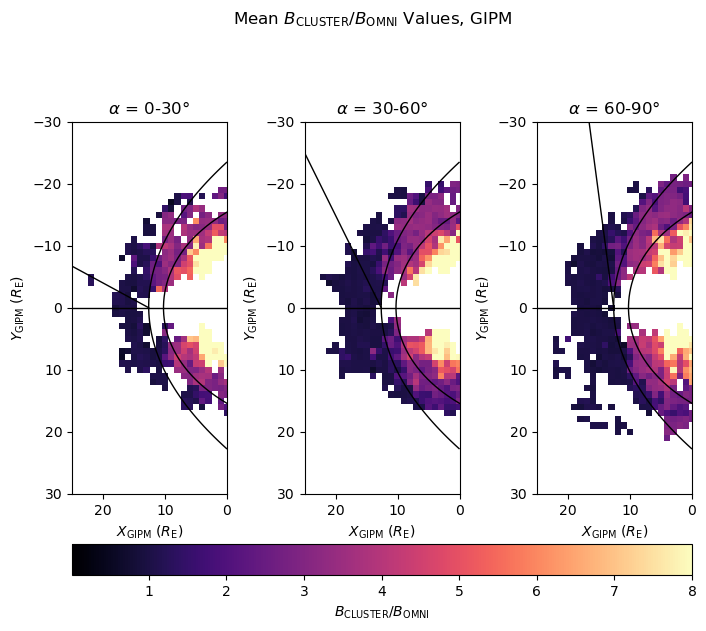

In [10]:
binned_plot(mean_rat_rad, mean_rat_spir, mean_rat_perp, 1)

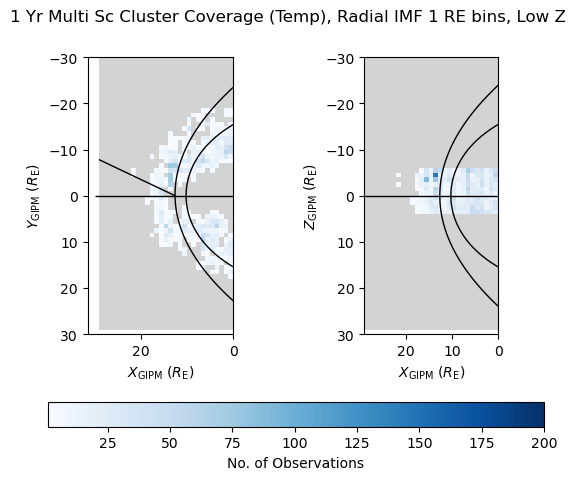

In [11]:
#histogram of interval LOCATIONS

#numpy hist. works from arrays

cluster_all_rad_low_Z = all_rad.loc[(all_rad['Cluster Loc GIPM Z']> -5) & (all_rad['Cluster Loc GIPM Z'] < 5)]
cluster_all_spir_low_Z = all_spir.loc[(all_spir['Cluster Loc GIPM Z']> -5) & (all_spir['Cluster Loc GIPM Z'] < 5)]
cluster_all_perp_low_Z = all_perp.loc[(all_perp['Cluster Loc GIPM Z']> -5) & (all_perp['Cluster Loc GIPM Z'] < 5)]

histo_plot(cluster_all_rad_low_Z, 1, XMA_all, 15)

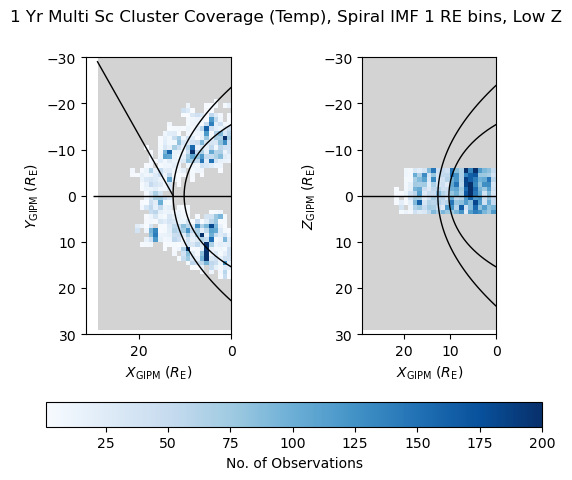

In [12]:
histo_plot(cluster_all_spir_low_Z, 1, XMA_all, 45)

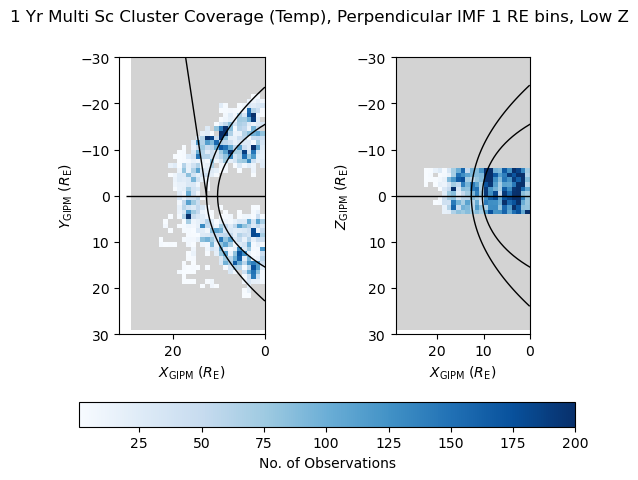

In [13]:
histo_plot(cluster_all_perp_low_Z, 1, XMA_all, 75)